In [20]:
from keras.layers import Conv2D, BatchNormalization, Input, GlobalAveragePooling2D, Dense, Reshape
from keras.models import Model, Sequential
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Deconvolution2D

import pandas as pd
import os
from keras.optimizers import Adam

In [21]:
# function for building the discriminator layers
def build_discriminator(start_filters, spatial_dim, filter_size):
    
    # function for building a CNN block for downsampling the image
    def add_discriminator_block(x, filters, filter_size):
        x = Conv2D(filters, filter_size, padding='same')(x)
        x = BatchNormalization()(x)
        x = Conv2D(filters, filter_size, padding='same', strides=2)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.3)(x)
        return x
    
    # input is an image with shape spatial_dim x spatial_dim and 3 channels
    inp = Input(shape=(spatial_dim, spatial_dim, 3))

    # design the discrimitor to downsample the image 4x
    x = add_discriminator_block(inp, start_filters, filter_size)
    x = add_discriminator_block(x, start_filters * 2, filter_size)
    x = add_discriminator_block(x, start_filters * 4, filter_size)
    x = add_discriminator_block(x, start_filters * 8, filter_size)
    
    # average and return a binary output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1, activation='sigmoid')(x)
    
    return Model(inputs=inp, outputs=x)

In [22]:
def build_generator(start_filters, filter_size, latent_dim):
      # function for building a CNN block for upsampling the image
    def add_generator_block(x, filters, filter_size):
        x = Deconvolution2D(filters, filter_size, strides=2, padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.3)(x)
        return x

    # input is a noise vector 
    inp = Input(shape=(latent_dim,))

    # projection of the noise vector into a tensor with 
    # same shape as last conv layer in discriminator
    x = Dense(4 * 4 * (start_filters * 8), input_dim=latent_dim)(inp)
    x = BatchNormalization()(x)
    x = Reshape(target_shape=(4, 4, start_filters * 8))(x)

    # design the generator to upsample the image 4x
    x = add_generator_block(x, start_filters * 4, filter_size)
    x = add_generator_block(x, start_filters * 2, filter_size)
    x = add_generator_block(x, start_filters, filter_size)
    x = add_generator_block(x, start_filters, filter_size)    

    # turn the output into a 3D tensor, an image with 3 channels 
    x = Conv2D(3, kernel_size=5, padding='same', activation='tanh')(x)
    
    return Model(inputs=inp, outputs=x)

In [23]:
# load celebrity images attributes
df_celeb = pd.read_csv('list_attr_celeba.csv')
TOTAL_SAMPLES = df_celeb.shape[0]

# we will downscale the images
SPATIAL_DIM = 64 
# size of noise vector
LATENT_DIM_GAN = 100 
# filter size in conv layer
FILTER_SIZE = 5
# number of filters in conv layer
NET_CAPACITY = 16
# batch size
BATCH_SIZE_GAN = 32
# interval for displaying generated images
PROGRESS_INTERVAL = 80 
# directory for storing generated images
ROOT_DIR = 'visualization'
if not os.path.isdir(ROOT_DIR):
    os.mkdir(ROOT_DIR)
    


def construct_models(verbose=False):
    ### discriminator
    discriminator = build_discriminator(NET_CAPACITY, SPATIAL_DIM, FILTER_SIZE)
    # compile discriminator
    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002), metrics=['mae'])

    ### generator
    # do not compile generator
    generator = build_generator(NET_CAPACITY, FILTER_SIZE, LATENT_DIM_GAN)

    ### DCGAN 
    gan = Sequential()
    gan.add(generator)
    gan.add(discriminator)
    discriminator.trainable = False 
    gan.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002), metrics=['mae'])

    if verbose: 
        generator.summary()
        discriminator.summary()
        gan.summary()
        
    return generator, discriminator, gan
  
generator_celeb, discriminator_celeb, gan_celeb = construct_models(verbose=True)

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_5 (Dense)              (None, 2048)              206848    
_________________________________________________________________
batch_normalization_34 (Batc (None, 2048)              8192      
_________________________________________________________________
reshape_2 (Reshape)          (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 8, 8, 64)          204864    
_________________________________________________________________
batch_normalization_35 (Batc (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 8, 8, 64)        

In [41]:
# helper function for selecting 'size' real images
# and downscaling them to lower dimension SPATIAL_DIM
def get_real_celebrity(df, size, total):
    cur_files = df.sample(frac=1).iloc[0:size]
    X = np.empty(shape=(size, SPATIAL_DIM, SPATIAL_DIM, 3))
    for i in range(0, size):
        file = cur_files.iloc[i]
        img_uri = 'img_align_celeba/img_align_celeba/' + file.image_id
        img = cv2.imread(img_uri)
        img = cv2.resize(img, (SPATIAL_DIM, SPATIAL_DIM))
        img = np.flip(img, axis=2)
        img = img.astype(np.float32) / 127.5 - 1.0
        X[i] = img
    return X

In [32]:
from PIL import Image 
im = Image.open(r"img_align_celeba/000004.jpg")
im.show()

Epoch 478


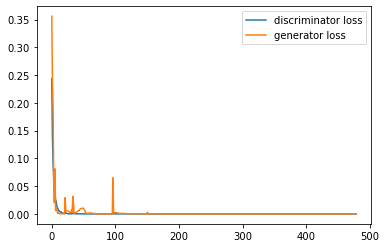

KeyboardInterrupt: 

In [42]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from IPython.display import clear_output
 
# number of discriminator updates per alternating training iteration
DISC_UPDATES = 1  
# number of generator updates per alternating training iteration
GEN_UPDATES = 1 

# function for training a GAN
def run_training(generator, discriminator, gan, df=df_celeb, start_it=0, num_epochs=1000, 
                 get_real_images=get_real_celebrity):
  # list for storing loss
    avg_loss_discriminator = []
    avg_loss_generator = []
    total_it = start_it

  # main training loop
    for epoch in range(num_epochs):

      # alternating training loop
        loss_discriminator = []
        loss_generator = []
        for it in range(200): 

          #### Discriminator training loop ####
            for i in range(DISC_UPDATES): 
              # select a random set of real images
                imgs_real = get_real_images(df, BATCH_SIZE_GAN, TOTAL_SAMPLES)
              # generate a set of random noise vectors
                noise = np.random.randn(BATCH_SIZE_GAN, LATENT_DIM_GAN)
              # generate a set of fake images using the generator
                imgs_fake = generator.predict(noise)
              # train the discriminator on real images with label 1
                d_loss_real = discriminator.train_on_batch(imgs_real, np.ones([BATCH_SIZE_GAN]))[1]
              # train the discriminator on fake images with label 0
                d_loss_fake = discriminator.train_on_batch(imgs_fake, np.zeros([BATCH_SIZE_GAN]))[1]

          # display some fake images for visual control of convergence
            if total_it % PROGRESS_INTERVAL == 0:
                plt.figure(figsize=(5,2))
                num_vis = min(BATCH_SIZE_GAN, 5)
                imgs_real = get_real_images(df, num_vis, TOTAL_SAMPLES)
                noise = np.random.randn(num_vis, LATENT_DIM_GAN)
                imgs_fake = generator.predict(noise)
                for obj_plot in [imgs_fake, imgs_real]:
                    plt.figure(figsize=(num_vis * 3, 3))
                    for b in range(num_vis):
                        disc_score = float(discriminator.predict(np.expand_dims(obj_plot[b], axis=0))[0])
                        plt.subplot(1, num_vis, b + 1)
                        plt.title(str(round(disc_score, 3)))
                        plt.imshow(obj_plot[b] * 0.5 + 0.5) 
                    if obj_plot is imgs_fake:
                        plt.savefig(os.path.join(ROOT_DIR, str(total_it).zfill(10) + '.jpg'), format='jpg', bbox_inches='tight')
                    plt.show()  

          #### Generator training loop ####
            loss = 0
            y = np.ones([BATCH_SIZE_GAN, 1]) 
            for j in range(GEN_UPDATES):
              # generate a set of random noise vectors
                noise = np.random.randn(BATCH_SIZE_GAN, LATENT_DIM_GAN)
              # train the generator on fake images with label 1
                loss += gan.train_on_batch(noise, y)[1]

          # store loss
            loss_discriminator.append((d_loss_real + d_loss_fake) / 2.)        
            loss_generator.append(loss / GEN_UPDATES)
            total_it += 1

      # visualize loss
        clear_output(True)
        print('Epoch', epoch)
        avg_loss_discriminator.append(np.mean(loss_discriminator))
        avg_loss_generator.append(np.mean(loss_generator))
        plt.plot(range(len(avg_loss_discriminator)), avg_loss_discriminator)
        plt.plot(range(len(avg_loss_generator)), avg_loss_generator)
        plt.legend(['discriminator loss', 'generator loss'])
        plt.show()

    return generator, discriminator, gan

generator_celeb, discriminator_celeb, gan_celeb = run_training(generator_celeb, 
                                                               discriminator_celeb, 
                                                               gan_celeb, 
                                                               num_epochs=500, 
                                                               df=df_celeb)